In [1]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0
#clone github repository
!git clone https://github.com/open-mmlab/mmsegmentation.git 
#install all requirements
!pip install -qr mmsegmentation/requirements.txt 
%cd /content/mmsegmentation
#install mmsegmentation in develop mode
!python setup.py develop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 235 kB 30.8 MB/s 
     |████████████████████████████████| 51 kB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.1 MB 4.6 MB/s 
     |████████████████████████████████| 190 kB 15.4 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 10209, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 10209 (delta 19), reused 55 (delta 12), pack-reused 10125
Receiving objects: 100% (10209/10209), 14.03 Mi

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#DataPath and DataCustomize

In [3]:
#declare global variables
root_dir= '/content/mmsegmentation/data/'
data_root= "/content/mmsegmentation/data/"

dataset= "my_dataset"


In [4]:
import os

#check file counts
train_imgs= data_root + dataset+'/img_dir/train'
val_imgs= data_root + dataset +'/img_dir/val'
train_gt= data_root + dataset+'/ann_dir/train'
val_gt= data_root + dataset+'/ann_dir/val'

#print the file count
print(len(os.listdir(train_imgs)))
print(len(os.listdir(val_imgs)))
print(len(os.listdir(train_gt)))
print(len(os.listdir(val_gt)))

378
48
378
48


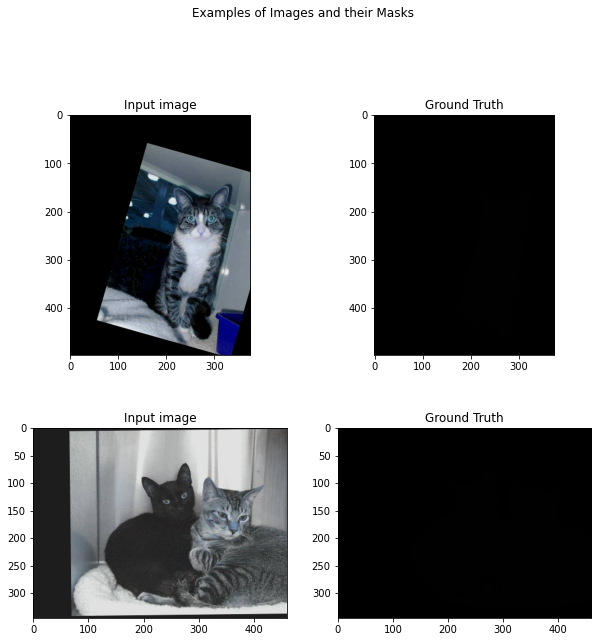

In [5]:
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob


PATH_TO_TRAIN_IMAGES_DIR= data_root+dataset+'/img_dir/train'
PATH_TO_LABEL_IMAGES_DIR= data_root+dataset+'/ann_dir/train'

TRAIN_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TRAIN_IMAGES_DIR, "*.jpg"))
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TRAIN_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

palette = [[128, 0, 128], [128, 0, 0], [255,255,77]] #dataset palette

display_num = 3
r_choices = np.random.choice(len(TRAIN_IMAGE_PATHS), display_num)

#visualize any 5 random images and their mask images
plt.figure(figsize=(10, 15))
for i in range(0, display_num, 2):
  img_num = r_choices[i // 2]
  img = mmcv.imread(TRAIN_IMAGE_PATHS[img_num])
  label = mmcv.imread(LABEL_PATHS[img_num])

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(img)
  plt.title("Input image")

  plt.subplot(display_num, 2, i + 2)
  plt.imshow(label)
  plt.title("Ground Truth")


plt.suptitle("Examples of Images and their Masks")
plt.show()

# MMSeg

In [6]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [7]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device
import torch

cfg_data_root = data_root+dataset
train_img_dir = 'img_dir/train'
train_ann_dir = 'ann_dir/train'
val_img_dir = 'img_dir/val'
val_ann_dir = 'ann_dir/val'

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes =3

# Modify dataset type and path
cfg.dataset_type = 'CustomDataset'
cfg.data_root = cfg_data_root

#batch size
cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu=4

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = train_img_dir
cfg.data.train.ann_dir = train_ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = None

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = val_img_dir
cfg.data.val.ann_dir = val_ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = None

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = val_img_dir
cfg.data.test.ann_dir = val_ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = None


# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 10000
cfg.log_config.interval = 200  ## # config to register logger hook,Interval to print the log (x-x gidecek)
cfg.evaluation.interval = 200 #The config to build the evaluation hook  (yazdirma)
cfg.checkpoint_config.interval = 1000 #Config to set the checkpoint hook (kayıt)

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [8]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import os.path as osp

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-07-31 14:20:12,296 - mmseg - INFO - Loaded 378 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.2 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:21:29,895 - mmseg - INFO - per class results:
2022-07-31 14:21:29,898 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 65.93 | 79.67 |
|    Cat     | 25.28 | 52.42 |
|    Dog     | 10.35 | 13.22 |
+------------+-------+-------+
2022-07-31 14:21:29,903 - mmseg - INFO - Summary:
2022-07-31 14:21:29,905 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 61.95 | 33.85 | 48.44 |
+-------+-------+-------+
2022-07-31 14:21:29,907 - mmseg - INFO - Iter(val) [48]	aAcc: 0.6195, mIoU: 0.3385, mAcc: 0.4844, IoU.Background: 0.6593, IoU.Cat: 0.2528, IoU.Dog: 0.1035, Acc.Background: 0.7967, Acc.Cat: 0.5242, Acc.Dog: 0.1322
2022-07-31 14:22:36,852 - mmseg - INFO - Iter [400/10000]	lr: 9.644e-03, eta: 0:56:05, time: 0.347, data_time: 0.036, memory: 2225, decode.loss_ce: 0.8607, decode.acc_seg: 53.9596, aux.loss_ce: 0.3345, aux.acc_seg: 53.9303, loss: 1.1952


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 22.7 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:22:38,987 - mmseg - INFO - per class results:
2022-07-31 14:22:38,988 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 50.65 | 61.67 |
|    Cat     | 17.86 | 36.52 |
|    Dog     | 15.53 | 28.86 |
+------------+-------+-------+
2022-07-31 14:22:38,991 - mmseg - INFO - Summary:
2022-07-31 14:22:38,994 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 50.77 | 28.01 | 42.35 |
+-------+-------+-------+
2022-07-31 14:22:38,997 - mmseg - INFO - Iter(val) [48]	aAcc: 0.5077, mIoU: 0.2801, mAcc: 0.4235, IoU.Background: 0.5065, IoU.Cat: 0.1786, IoU.Dog: 0.1553, Acc.Background: 0.6167, Acc.Cat: 0.3652, Acc.Dog: 0.2886
2022-07-31 14:23:48,028 - mmseg - INFO - Iter [600/10000]	lr: 9.465e-03, eta: 0:55:12, time: 0.356, data_time: 0.035, memory: 2225, decode.loss_ce: 0.8475, decode.acc_seg: 54.4974, aux.loss_ce: 0.3342, aux.acc_seg: 54.2505, loss: 1.1817


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 22.8 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:23:50,141 - mmseg - INFO - per class results:
2022-07-31 14:23:50,144 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 68.62 | 93.28 |
|    Cat     |  7.52 |  7.89 |
|    Dog     | 26.08 | 38.92 |
+------------+-------+-------+
2022-07-31 14:23:50,146 - mmseg - INFO - Summary:
2022-07-31 14:23:50,150 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 67.2 | 34.07 | 46.7 |
+------+-------+------+
2022-07-31 14:23:50,153 - mmseg - INFO - Iter(val) [48]	aAcc: 0.6720, mIoU: 0.3407, mAcc: 0.4670, IoU.Background: 0.6862, IoU.Cat: 0.0752, IoU.Dog: 0.2608, Acc.Background: 0.9328, Acc.Cat: 0.0789, Acc.Dog: 0.3892
2022-07-31 14:25:00,091 - mmseg - INFO - Iter [800/10000]	lr: 9.285e-03, eta: 0:54:19, time: 0.360, data_time: 0.034, memory: 2226, decode.loss_ce: 0.7977, decode.acc_seg: 55.4359, aux.loss_ce: 0.3233, aux.acc_seg: 54.7669, loss: 1.1210


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 22.6 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:25:02,223 - mmseg - INFO - per class results:
2022-07-31 14:25:02,225 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 70.33 |  90.7 |
|    Cat     | 11.67 | 12.22 |
|    Dog     | 32.15 |  52.4 |
+------------+-------+-------+
2022-07-31 14:25:02,228 - mmseg - INFO - Summary:
2022-07-31 14:25:02,234 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.96 | 38.05 | 51.77 |
+-------+-------+-------+
2022-07-31 14:25:02,242 - mmseg - INFO - Iter(val) [48]	aAcc: 0.6896, mIoU: 0.3805, mAcc: 0.5177, IoU.Background: 0.7033, IoU.Cat: 0.1167, IoU.Dog: 0.3215, Acc.Background: 0.9070, Acc.Cat: 0.1222, Acc.Dog: 0.5240
2022-07-31 14:26:12,963 - mmseg - INFO - Saving checkpoint at 1000 iterations
2022-07-31 14:26:15,320 - mmseg - INFO - Iter [1000/10000]	lr: 9.105e-03, eta: 0:53:48, time: 0.376, data_time: 0.034, memory: 2226, decode.loss_ce: 0.7584, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 21.5 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:26:17,574 - mmseg - INFO - per class results:
2022-07-31 14:26:17,578 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 71.06 | 87.77 |
|    Cat     |  3.08 |  3.13 |
|    Dog     | 29.85 | 58.46 |
+------------+-------+-------+
2022-07-31 14:26:17,581 - mmseg - INFO - Summary:
2022-07-31 14:26:17,584 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.63 | 34.66 | 49.79 |
+-------+-------+-------+
2022-07-31 14:26:17,587 - mmseg - INFO - Iter(val) [48]	aAcc: 0.6663, mIoU: 0.3466, mAcc: 0.4979, IoU.Background: 0.7106, IoU.Cat: 0.0308, IoU.Dog: 0.2985, Acc.Background: 0.8777, Acc.Cat: 0.0313, Acc.Dog: 0.5846
2022-07-31 14:27:28,848 - mmseg - INFO - Iter [1200/10000]	lr: 8.925e-03, eta: 0:52:49, time: 0.367, data_time: 0.035, memory: 2226, decode.loss_ce: 0.8002, decode.acc_seg: 56.6376, aux.loss_ce: 0.3247, aux.acc_seg: 54.8044, loss: 1.1249


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 22.5 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:27:30,990 - mmseg - INFO - per class results:
2022-07-31 14:27:30,992 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 65.89 |  97.6 |
|    Cat     |  3.92 |  4.1  |
|    Dog     | 14.27 | 17.28 |
+------------+-------+-------+
2022-07-31 14:27:30,994 - mmseg - INFO - Summary:
2022-07-31 14:27:30,997 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 65.06 | 28.03 | 39.66 |
+-------+-------+-------+
2022-07-31 14:27:31,004 - mmseg - INFO - Iter(val) [48]	aAcc: 0.6506, mIoU: 0.2803, mAcc: 0.3966, IoU.Background: 0.6589, IoU.Cat: 0.0392, IoU.Dog: 0.1427, Acc.Background: 0.9760, Acc.Cat: 0.0410, Acc.Dog: 0.1728
2022-07-31 14:28:42,654 - mmseg - INFO - Iter [1400/10000]	lr: 8.744e-03, eta: 0:51:48, time: 0.369, data_time: 0.034, memory: 2226, decode.loss_ce: 0.7616, decode.acc_seg: 57.4505, aux.loss_ce: 0.3110, aux.acc_seg: 56.0742, loss: 1.0726


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 22.3 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:28:44,819 - mmseg - INFO - per class results:
2022-07-31 14:28:44,821 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 70.96 | 91.14 |
|    Cat     |  0.5  |  0.51 |
|    Dog     | 25.63 | 46.89 |
+------------+-------+-------+
2022-07-31 14:28:44,824 - mmseg - INFO - Summary:
2022-07-31 14:28:44,829 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.04 | 32.36 | 46.18 |
+-------+-------+-------+
2022-07-31 14:28:44,835 - mmseg - INFO - Iter(val) [48]	aAcc: 0.6604, mIoU: 0.3236, mAcc: 0.4618, IoU.Background: 0.7096, IoU.Cat: 0.0050, IoU.Dog: 0.2563, Acc.Background: 0.9114, Acc.Cat: 0.0051, Acc.Dog: 0.4689
2022-07-31 14:29:58,661 - mmseg - INFO - Iter [1600/10000]	lr: 8.563e-03, eta: 0:50:55, time: 0.380, data_time: 0.046, memory: 2226, decode.loss_ce: 0.7566, decode.acc_seg: 57.3982, aux.loss_ce: 0.3120, aux.acc_seg: 55.6830, loss: 1.0685


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 22.7 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:30:00,785 - mmseg - INFO - per class results:
2022-07-31 14:30:00,788 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 69.92 | 84.59 |
|    Cat     |  0.0  |  0.0  |
|    Dog     | 33.29 | 69.33 |
+------------+-------+-------+
2022-07-31 14:30:00,789 - mmseg - INFO - Summary:
2022-07-31 14:30:00,792 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 66.14 | 34.4 | 51.31 |
+-------+------+-------+
2022-07-31 14:30:00,797 - mmseg - INFO - Iter(val) [48]	aAcc: 0.6614, mIoU: 0.3440, mAcc: 0.5131, IoU.Background: 0.6992, IoU.Cat: 0.0000, IoU.Dog: 0.3329, Acc.Background: 0.8459, Acc.Cat: 0.0000, Acc.Dog: 0.6933
2022-07-31 14:31:12,531 - mmseg - INFO - Iter [1800/10000]	lr: 8.382e-03, eta: 0:49:47, time: 0.369, data_time: 0.034, memory: 2226, decode.loss_ce: 0.7438, decode.acc_seg: 59.0999, aux.loss_ce: 0.3069, aux.acc_seg: 57.8633, loss: 1.0507


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 22.2 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:31:14,703 - mmseg - INFO - per class results:
2022-07-31 14:31:14,706 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 70.49 | 87.57 |
|    Cat     |  35.9 | 59.38 |
|    Dog     | 15.77 | 18.77 |
+------------+-------+-------+
2022-07-31 14:31:14,710 - mmseg - INFO - Summary:
2022-07-31 14:31:14,714 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.22 | 40.72 | 55.24 |
+-------+-------+-------+
2022-07-31 14:31:14,717 - mmseg - INFO - Iter(val) [48]	aAcc: 0.6922, mIoU: 0.4072, mAcc: 0.5524, IoU.Background: 0.7049, IoU.Cat: 0.3590, IoU.Dog: 0.1577, Acc.Background: 0.8757, Acc.Cat: 0.5938, Acc.Dog: 0.1877
2022-07-31 14:32:26,502 - mmseg - INFO - Saving checkpoint at 2000 iterations
2022-07-31 14:32:28,647 - mmseg - INFO - Iter [2000/10000]	lr: 8.200e-03, eta: 0:48:48, time: 0.381, data_time: 0.035, memory: 2226, decode.loss_ce: 0.7460, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.8 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:32:30,974 - mmseg - INFO - per class results:
2022-07-31 14:32:30,977 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 69.94 | 88.57 |
|    Cat     | 26.42 | 36.59 |
|    Dog     | 23.42 | 33.06 |
+------------+-------+-------+
2022-07-31 14:32:30,980 - mmseg - INFO - Summary:
2022-07-31 14:32:30,983 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 68.4 | 39.93 | 52.74 |
+------+-------+-------+
2022-07-31 14:32:30,986 - mmseg - INFO - Iter(val) [48]	aAcc: 0.6840, mIoU: 0.3993, mAcc: 0.5274, IoU.Background: 0.6994, IoU.Cat: 0.2642, IoU.Dog: 0.2342, Acc.Background: 0.8857, Acc.Cat: 0.3659, Acc.Dog: 0.3306
2022-07-31 14:33:42,802 - mmseg - INFO - Iter [2200/10000]	lr: 8.017e-03, eta: 0:47:38, time: 0.371, data_time: 0.036, memory: 2226, decode.loss_ce: 0.7207, decode.acc_seg: 59.9181, aux.loss_ce: 0.2993, aux.acc_seg: 58.0598, loss: 1.0201


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.4 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:33:45,163 - mmseg - INFO - per class results:
2022-07-31 14:33:45,165 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 69.42 |  81.3 |
|    Cat     | 32.78 | 36.25 |
|    Dog     | 36.86 | 68.98 |
+------------+-------+-------+
2022-07-31 14:33:45,166 - mmseg - INFO - Summary:
2022-07-31 14:33:45,170 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.67 | 46.35 | 62.18 |
+-------+-------+-------+
2022-07-31 14:33:45,173 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7067, mIoU: 0.4635, mAcc: 0.6218, IoU.Background: 0.6942, IoU.Cat: 0.3278, IoU.Dog: 0.3686, Acc.Background: 0.8130, Acc.Cat: 0.3625, Acc.Dog: 0.6898
2022-07-31 14:34:57,023 - mmseg - INFO - Iter [2400/10000]	lr: 7.834e-03, eta: 0:46:27, time: 0.371, data_time: 0.036, memory: 2226, decode.loss_ce: 0.7324, decode.acc_seg: 60.0328, aux.loss_ce: 0.3052, aux.acc_seg: 57.7312, loss: 1.0375


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.7 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:34:59,358 - mmseg - INFO - per class results:
2022-07-31 14:34:59,361 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 72.68 | 86.01 |
|    Cat     | 22.41 | 24.04 |
|    Dog     | 39.03 | 70.62 |
+------------+-------+-------+
2022-07-31 14:34:59,367 - mmseg - INFO - Summary:
2022-07-31 14:34:59,368 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.69 | 44.71 | 60.23 |
+-------+-------+-------+
2022-07-31 14:34:59,372 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7169, mIoU: 0.4471, mAcc: 0.6023, IoU.Background: 0.7268, IoU.Cat: 0.2241, IoU.Dog: 0.3903, Acc.Background: 0.8601, Acc.Cat: 0.2404, Acc.Dog: 0.7062
2022-07-31 14:36:11,181 - mmseg - INFO - Iter [2600/10000]	lr: 7.651e-03, eta: 0:45:16, time: 0.371, data_time: 0.036, memory: 2226, decode.loss_ce: 0.7032, decode.acc_seg: 61.6512, aux.loss_ce: 0.2934, aux.acc_seg: 59.1185, loss: 0.9966


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 22.0 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:36:13,369 - mmseg - INFO - per class results:
2022-07-31 14:36:13,372 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 74.39 |  88.1 |
|    Cat     | 22.83 | 25.89 |
|    Dog     | 35.83 | 62.47 |
+------------+-------+-------+
2022-07-31 14:36:13,374 - mmseg - INFO - Summary:
2022-07-31 14:36:13,378 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.78 | 44.35 | 58.82 |
+-------+-------+-------+
2022-07-31 14:36:13,381 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7178, mIoU: 0.4435, mAcc: 0.5882, IoU.Background: 0.7439, IoU.Cat: 0.2283, IoU.Dog: 0.3583, Acc.Background: 0.8810, Acc.Cat: 0.2589, Acc.Dog: 0.6247
2022-07-31 14:37:25,247 - mmseg - INFO - Iter [2800/10000]	lr: 7.467e-03, eta: 0:44:04, time: 0.370, data_time: 0.035, memory: 2226, decode.loss_ce: 0.6926, decode.acc_seg: 62.5729, aux.loss_ce: 0.2937, aux.acc_seg: 59.4229, loss: 0.9863


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 21.6 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:37:27,479 - mmseg - INFO - per class results:
2022-07-31 14:37:27,487 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 71.84 | 89.56 |
|    Cat     | 34.71 | 48.38 |
|    Dog     | 32.91 | 40.94 |
+------------+-------+-------+
2022-07-31 14:37:27,488 - mmseg - INFO - Summary:
2022-07-31 14:37:27,492 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.69 | 46.49 | 59.62 |
+-------+-------+-------+
2022-07-31 14:37:27,496 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7269, mIoU: 0.4649, mAcc: 0.5962, IoU.Background: 0.7184, IoU.Cat: 0.3471, IoU.Dog: 0.3291, Acc.Background: 0.8956, Acc.Cat: 0.4838, Acc.Dog: 0.4094
2022-07-31 14:38:39,424 - mmseg - INFO - Saving checkpoint at 3000 iterations
2022-07-31 14:38:41,459 - mmseg - INFO - Iter [3000/10000]	lr: 7.283e-03, eta: 0:42:57, time: 0.381, data_time: 0.035, memory: 2226, decode.loss_ce: 0.7016, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 19.4 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:38:43,953 - mmseg - INFO - per class results:
2022-07-31 14:38:43,955 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 70.73 | 89.64 |
|    Cat     | 14.95 |  15.6 |
|    Dog     | 32.48 | 54.72 |
+------------+-------+-------+
2022-07-31 14:38:43,958 - mmseg - INFO - Summary:
2022-07-31 14:38:43,963 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.37 | 39.38 | 53.32 |
+-------+-------+-------+
2022-07-31 14:38:43,966 - mmseg - INFO - Iter(val) [48]	aAcc: 0.6937, mIoU: 0.3938, mAcc: 0.5332, IoU.Background: 0.7073, IoU.Cat: 0.1495, IoU.Dog: 0.3248, Acc.Background: 0.8964, Acc.Cat: 0.1560, Acc.Dog: 0.5472
2022-07-31 14:39:58,061 - mmseg - INFO - Iter [3200/10000]	lr: 7.098e-03, eta: 0:41:50, time: 0.383, data_time: 0.047, memory: 2226, decode.loss_ce: 0.6651, decode.acc_seg: 64.4846, aux.loss_ce: 0.2848, aux.acc_seg: 60.8901, loss: 0.9499


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.8 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:40:00,381 - mmseg - INFO - per class results:
2022-07-31 14:40:00,385 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 73.47 | 87.42 |
|    Cat     | 36.99 | 54.82 |
|    Dog     | 34.54 | 45.23 |
+------------+-------+-------+
2022-07-31 14:40:00,386 - mmseg - INFO - Summary:
2022-07-31 14:40:00,393 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.36 | 48.33 | 62.49 |
+-------+-------+-------+
2022-07-31 14:40:00,395 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7336, mIoU: 0.4833, mAcc: 0.6249, IoU.Background: 0.7347, IoU.Cat: 0.3699, IoU.Dog: 0.3454, Acc.Background: 0.8742, Acc.Cat: 0.5482, Acc.Dog: 0.4523
2022-07-31 14:41:12,122 - mmseg - INFO - Iter [3400/10000]	lr: 6.912e-03, eta: 0:40:37, time: 0.370, data_time: 0.035, memory: 2226, decode.loss_ce: 0.6433, decode.acc_seg: 65.4606, aux.loss_ce: 0.2763, aux.acc_seg: 61.2601, loss: 0.9196


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.8 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:41:14,446 - mmseg - INFO - per class results:
2022-07-31 14:41:14,447 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 73.19 | 87.17 |
|    Cat     | 32.61 | 55.29 |
|    Dog     | 23.67 | 29.81 |
+------------+-------+-------+
2022-07-31 14:41:14,450 - mmseg - INFO - Summary:
2022-07-31 14:41:14,458 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.34 | 43.16 | 57.42 |
+-------+-------+-------+
2022-07-31 14:41:14,459 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7034, mIoU: 0.4316, mAcc: 0.5742, IoU.Background: 0.7319, IoU.Cat: 0.3261, IoU.Dog: 0.2367, Acc.Background: 0.8717, Acc.Cat: 0.5529, Acc.Dog: 0.2981
2022-07-31 14:42:26,337 - mmseg - INFO - Iter [3600/10000]	lr: 6.726e-03, eta: 0:39:23, time: 0.371, data_time: 0.035, memory: 2226, decode.loss_ce: 0.6296, decode.acc_seg: 67.6799, aux.loss_ce: 0.2726, aux.acc_seg: 62.9979, loss: 0.9021


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.7 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:42:28,665 - mmseg - INFO - per class results:
2022-07-31 14:42:28,670 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background |  77.0 |  87.6 |
|    Cat     | 40.68 | 57.68 |
|    Dog     | 39.04 | 55.04 |
+------------+-------+-------+
2022-07-31 14:42:28,671 - mmseg - INFO - Summary:
2022-07-31 14:42:28,680 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.87 | 52.24 | 66.77 |
+-------+-------+-------+
2022-07-31 14:42:28,681 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7587, mIoU: 0.5224, mAcc: 0.6677, IoU.Background: 0.7700, IoU.Cat: 0.4068, IoU.Dog: 0.3904, Acc.Background: 0.8760, Acc.Cat: 0.5768, Acc.Dog: 0.5504
2022-07-31 14:43:40,534 - mmseg - INFO - Iter [3800/10000]	lr: 6.539e-03, eta: 0:38:10, time: 0.371, data_time: 0.035, memory: 2226, decode.loss_ce: 0.6372, decode.acc_seg: 66.7291, aux.loss_ce: 0.2766, aux.acc_seg: 62.1013, loss: 0.9138


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 21.1 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:43:42,819 - mmseg - INFO - per class results:
2022-07-31 14:43:42,821 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background |  73.5 | 81.29 |
|    Cat     | 32.11 | 40.87 |
|    Dog     | 41.74 | 75.67 |
+------------+-------+-------+
2022-07-31 14:43:42,829 - mmseg - INFO - Summary:
2022-07-31 14:43:42,834 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 72.8 | 49.12 | 65.95 |
+------+-------+-------+
2022-07-31 14:43:42,838 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7280, mIoU: 0.4912, mAcc: 0.6595, IoU.Background: 0.7350, IoU.Cat: 0.3211, IoU.Dog: 0.4174, Acc.Background: 0.8129, Acc.Cat: 0.4087, Acc.Dog: 0.7567
2022-07-31 14:44:54,637 - mmseg - INFO - Saving checkpoint at 4000 iterations
2022-07-31 14:44:56,764 - mmseg - INFO - Iter [4000/10000]	lr: 6.352e-03, eta: 0:37:00, time: 0.381, data_time: 0.035, memory: 2226, decode.loss_ce: 0.6161, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.9 task/s, elapsed: 3s, ETA:     0s

2022-07-31 14:44:59,306 - mmseg - INFO - per class results:
2022-07-31 14:44:59,308 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background |  75.1 |  85.0 |
|    Cat     | 40.16 | 61.58 |
|    Dog     | 37.08 | 51.85 |
+------------+-------+-------+
2022-07-31 14:44:59,311 - mmseg - INFO - Summary:
2022-07-31 14:44:59,316 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.35 | 50.78 | 66.14 |
+-------+-------+-------+
2022-07-31 14:44:59,319 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7435, mIoU: 0.5078, mAcc: 0.6614, IoU.Background: 0.7510, IoU.Cat: 0.4016, IoU.Dog: 0.3708, Acc.Background: 0.8500, Acc.Cat: 0.6158, Acc.Dog: 0.5185
2022-07-31 14:46:11,201 - mmseg - INFO - Iter [4200/10000]	lr: 6.164e-03, eta: 0:35:46, time: 0.372, data_time: 0.037, memory: 2226, decode.loss_ce: 0.6088, decode.acc_seg: 68.2369, aux.loss_ce: 0.2693, aux.acc_seg: 63.9106, loss: 0.8781


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.7 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:46:13,528 - mmseg - INFO - per class results:
2022-07-31 14:46:13,530 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 77.06 |  85.7 |
|    Cat     | 44.14 | 52.73 |
|    Dog     | 46.61 | 75.25 |
+------------+-------+-------+
2022-07-31 14:46:13,532 - mmseg - INFO - Summary:
2022-07-31 14:46:13,537 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.65 | 55.93 | 71.23 |
+-------+-------+-------+
2022-07-31 14:46:13,541 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7765, mIoU: 0.5593, mAcc: 0.7123, IoU.Background: 0.7706, IoU.Cat: 0.4414, IoU.Dog: 0.4661, Acc.Background: 0.8570, Acc.Cat: 0.5273, Acc.Dog: 0.7525
2022-07-31 14:47:25,310 - mmseg - INFO - Iter [4400/10000]	lr: 5.976e-03, eta: 0:34:32, time: 0.371, data_time: 0.035, memory: 2226, decode.loss_ce: 0.6009, decode.acc_seg: 68.5078, aux.loss_ce: 0.2632, aux.acc_seg: 64.3106, loss: 0.8640


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 21.1 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:47:27,601 - mmseg - INFO - per class results:
2022-07-31 14:47:27,603 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 76.91 | 86.83 |
|    Cat     | 47.67 | 69.02 |
|    Dog     | 41.12 | 54.69 |
+------------+-------+-------+
2022-07-31 14:47:27,605 - mmseg - INFO - Summary:
2022-07-31 14:47:27,609 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.41 | 55.24 | 70.18 |
+-------+-------+-------+
2022-07-31 14:47:27,611 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7741, mIoU: 0.5524, mAcc: 0.7018, IoU.Background: 0.7691, IoU.Cat: 0.4767, IoU.Dog: 0.4112, Acc.Background: 0.8683, Acc.Cat: 0.6902, Acc.Dog: 0.5469
2022-07-31 14:48:39,406 - mmseg - INFO - Iter [4600/10000]	lr: 5.787e-03, eta: 0:33:18, time: 0.370, data_time: 0.035, memory: 2226, decode.loss_ce: 0.5769, decode.acc_seg: 69.9098, aux.loss_ce: 0.2577, aux.acc_seg: 64.8549, loss: 0.8346


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.8 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:48:41,721 - mmseg - INFO - per class results:
2022-07-31 14:48:41,723 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 77.98 | 87.13 |
|    Cat     | 38.22 |  63.8 |
|    Dog     | 32.94 | 43.16 |
+------------+-------+-------+
2022-07-31 14:48:41,725 - mmseg - INFO - Summary:
2022-07-31 14:48:41,733 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.43 | 49.71 | 64.7 |
+-------+-------+------+
2022-07-31 14:48:41,734 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7443, mIoU: 0.4971, mAcc: 0.6470, IoU.Background: 0.7798, IoU.Cat: 0.3822, IoU.Dog: 0.3294, Acc.Background: 0.8713, Acc.Cat: 0.6380, Acc.Dog: 0.4316
2022-07-31 14:49:55,687 - mmseg - INFO - Iter [4800/10000]	lr: 5.597e-03, eta: 0:32:07, time: 0.381, data_time: 0.047, memory: 2226, decode.loss_ce: 0.5941, decode.acc_seg: 69.4740, aux.loss_ce: 0.2648, aux.acc_seg: 64.3374, loss: 0.8588


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.7 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:49:58,013 - mmseg - INFO - per class results:
2022-07-31 14:49:58,014 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 77.32 | 94.64 |
|    Cat     | 49.88 | 63.64 |
|    Dog     | 34.73 | 39.39 |
+------------+-------+-------+
2022-07-31 14:49:58,015 - mmseg - INFO - Summary:
2022-07-31 14:49:58,018 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.37 | 53.98 | 65.89 |
+-------+-------+-------+
2022-07-31 14:49:58,027 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7837, mIoU: 0.5398, mAcc: 0.6589, IoU.Background: 0.7732, IoU.Cat: 0.4988, IoU.Dog: 0.3473, Acc.Background: 0.9464, Acc.Cat: 0.6364, Acc.Dog: 0.3939
2022-07-31 14:51:09,812 - mmseg - INFO - Saving checkpoint at 5000 iterations
2022-07-31 14:51:11,892 - mmseg - INFO - Iter [5000/10000]	lr: 5.406e-03, eta: 0:30:55, time: 0.381, data_time: 0.035, memory: 2226, decode.loss_ce: 0.5889, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 19.1 task/s, elapsed: 3s, ETA:     0s

2022-07-31 14:51:14,410 - mmseg - INFO - per class results:
2022-07-31 14:51:14,411 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 78.17 | 87.88 |
|    Cat     | 42.08 |  53.5 |
|    Dog     |  44.9 | 67.43 |
+------------+-------+-------+
2022-07-31 14:51:14,413 - mmseg - INFO - Summary:
2022-07-31 14:51:14,419 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 77.65 | 55.05 | 69.6 |
+-------+-------+------+
2022-07-31 14:51:14,421 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7765, mIoU: 0.5505, mAcc: 0.6960, IoU.Background: 0.7817, IoU.Cat: 0.4208, IoU.Dog: 0.4490, Acc.Background: 0.8788, Acc.Cat: 0.5350, Acc.Dog: 0.6743
2022-07-31 14:52:26,365 - mmseg - INFO - Iter [5200/10000]	lr: 5.215e-03, eta: 0:29:41, time: 0.372, data_time: 0.037, memory: 2226, decode.loss_ce: 0.5625, decode.acc_seg: 71.7545, aux.loss_ce: 0.2595, aux.acc_seg: 65.6271, loss: 0.8220


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.0 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:52:28,782 - mmseg - INFO - per class results:
2022-07-31 14:52:28,785 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 77.98 | 88.25 |
|    Cat     | 48.35 |  64.3 |
|    Dog     | 50.84 | 66.72 |
+------------+-------+-------+
2022-07-31 14:52:28,787 - mmseg - INFO - Summary:
2022-07-31 14:52:28,794 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.73 | 59.05 | 73.09 |
+-------+-------+-------+
2022-07-31 14:52:28,795 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7973, mIoU: 0.5905, mAcc: 0.7309, IoU.Background: 0.7798, IoU.Cat: 0.4835, IoU.Dog: 0.5084, Acc.Background: 0.8825, Acc.Cat: 0.6430, Acc.Dog: 0.6672
2022-07-31 14:53:40,653 - mmseg - INFO - Iter [5400/10000]	lr: 5.023e-03, eta: 0:28:27, time: 0.371, data_time: 0.036, memory: 2226, decode.loss_ce: 0.5528, decode.acc_seg: 72.0220, aux.loss_ce: 0.2513, aux.acc_seg: 66.1839, loss: 0.8041


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.0 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:53:43,064 - mmseg - INFO - per class results:
2022-07-31 14:53:43,067 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 79.01 | 85.57 |
|    Cat     | 44.76 | 85.07 |
|    Dog     | 32.24 | 36.09 |
+------------+-------+-------+
2022-07-31 14:53:43,070 - mmseg - INFO - Summary:
2022-07-31 14:53:43,074 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 76.0 | 52.01 | 68.91 |
+------+-------+-------+
2022-07-31 14:53:43,077 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7600, mIoU: 0.5201, mAcc: 0.6891, IoU.Background: 0.7901, IoU.Cat: 0.4476, IoU.Dog: 0.3224, Acc.Background: 0.8557, Acc.Cat: 0.8507, Acc.Dog: 0.3609
2022-07-31 14:54:54,950 - mmseg - INFO - Iter [5600/10000]	lr: 4.830e-03, eta: 0:27:12, time: 0.371, data_time: 0.035, memory: 2226, decode.loss_ce: 0.5534, decode.acc_seg: 72.8689, aux.loss_ce: 0.2564, aux.acc_seg: 66.7275, loss: 0.8098


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.0 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:54:57,361 - mmseg - INFO - per class results:
2022-07-31 14:54:57,363 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 78.64 | 94.62 |
|    Cat     | 45.85 | 59.46 |
|    Dog     |  42.8 | 48.45 |
+------------+-------+-------+
2022-07-31 14:54:57,364 - mmseg - INFO - Summary:
2022-07-31 14:54:57,369 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.33 | 55.76 | 67.51 |
+-------+-------+-------+
2022-07-31 14:54:57,371 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7933, mIoU: 0.5576, mAcc: 0.6751, IoU.Background: 0.7864, IoU.Cat: 0.4585, IoU.Dog: 0.4280, Acc.Background: 0.9462, Acc.Cat: 0.5946, Acc.Dog: 0.4845
2022-07-31 14:56:09,187 - mmseg - INFO - Iter [5800/10000]	lr: 4.636e-03, eta: 0:25:58, time: 0.371, data_time: 0.036, memory: 2226, decode.loss_ce: 0.5561, decode.acc_seg: 72.4322, aux.loss_ce: 0.2582, aux.acc_seg: 65.9823, loss: 0.8143


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.0 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:56:11,594 - mmseg - INFO - per class results:
2022-07-31 14:56:11,596 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 78.12 | 83.58 |
|    Cat     | 50.52 | 80.17 |
|    Dog     | 50.17 | 64.66 |
+------------+-------+-------+
2022-07-31 14:56:11,598 - mmseg - INFO - Summary:
2022-07-31 14:56:11,607 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.33 | 59.6 | 76.14 |
+-------+------+-------+
2022-07-31 14:56:11,610 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7933, mIoU: 0.5960, mAcc: 0.7614, IoU.Background: 0.7812, IoU.Cat: 0.5052, IoU.Dog: 0.5017, Acc.Background: 0.8358, Acc.Cat: 0.8017, Acc.Dog: 0.6466
2022-07-31 14:57:23,488 - mmseg - INFO - Saving checkpoint at 6000 iterations
2022-07-31 14:57:25,621 - mmseg - INFO - Iter [6000/10000]	lr: 4.441e-03, eta: 0:24:45, time: 0.382, data_time: 0.036, memory: 2226, decode.loss_ce: 0.5253, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 19.1 task/s, elapsed: 3s, ETA:     0s

2022-07-31 14:57:28,147 - mmseg - INFO - per class results:
2022-07-31 14:57:28,149 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 80.01 | 88.99 |
|    Cat     | 53.83 | 73.65 |
|    Dog     | 52.27 | 64.98 |
+------------+-------+-------+
2022-07-31 14:57:28,152 - mmseg - INFO - Summary:
2022-07-31 14:57:28,157 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.58 | 62.04 | 75.87 |
+-------+-------+-------+
2022-07-31 14:57:28,160 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8158, mIoU: 0.6204, mAcc: 0.7587, IoU.Background: 0.8001, IoU.Cat: 0.5383, IoU.Dog: 0.5227, Acc.Background: 0.8899, Acc.Cat: 0.7365, Acc.Dog: 0.6498
2022-07-31 14:58:40,058 - mmseg - INFO - Iter [6200/10000]	lr: 4.245e-03, eta: 0:23:31, time: 0.372, data_time: 0.037, memory: 2226, decode.loss_ce: 0.5100, decode.acc_seg: 74.0808, aux.loss_ce: 0.2421, aux.acc_seg: 68.1161, loss: 0.7521


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.4 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:58:42,418 - mmseg - INFO - per class results:
2022-07-31 14:58:42,420 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background |  79.4 |  87.1 |
|    Cat     | 44.47 | 72.12 |
|    Dog     | 43.85 | 54.12 |
+------------+-------+-------+
2022-07-31 14:58:42,422 - mmseg - INFO - Summary:
2022-07-31 14:58:42,425 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.04 | 55.9 | 71.11 |
+-------+------+-------+
2022-07-31 14:58:42,434 - mmseg - INFO - Iter(val) [48]	aAcc: 0.7804, mIoU: 0.5590, mAcc: 0.7111, IoU.Background: 0.7940, IoU.Cat: 0.4447, IoU.Dog: 0.4385, Acc.Background: 0.8710, Acc.Cat: 0.7212, Acc.Dog: 0.5412
2022-07-31 14:59:56,532 - mmseg - INFO - Iter [6400/10000]	lr: 4.048e-03, eta: 0:22:18, time: 0.382, data_time: 0.047, memory: 2226, decode.loss_ce: 0.5136, decode.acc_seg: 74.3196, aux.loss_ce: 0.2439, aux.acc_seg: 67.5189, loss: 0.7575


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.1 task/s, elapsed: 2s, ETA:     0s

2022-07-31 14:59:58,928 - mmseg - INFO - per class results:
2022-07-31 14:59:58,931 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 79.92 | 86.75 |
|    Cat     | 56.92 | 73.97 |
|    Dog     |  54.4 | 74.55 |
+------------+-------+-------+
2022-07-31 14:59:58,933 - mmseg - INFO - Summary:
2022-07-31 14:59:58,939 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 82.07 | 63.75 | 78.42 |
+-------+-------+-------+
2022-07-31 14:59:58,944 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8207, mIoU: 0.6375, mAcc: 0.7842, IoU.Background: 0.7992, IoU.Cat: 0.5692, IoU.Dog: 0.5440, Acc.Background: 0.8675, Acc.Cat: 0.7397, Acc.Dog: 0.7455
2022-07-31 15:01:10,777 - mmseg - INFO - Iter [6600/10000]	lr: 3.850e-03, eta: 0:21:04, time: 0.371, data_time: 0.036, memory: 2226, decode.loss_ce: 0.5017, decode.acc_seg: 75.4151, aux.loss_ce: 0.2409, aux.acc_seg: 68.6975, loss: 0.7426


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 20.2 task/s, elapsed: 2s, ETA:     0s

2022-07-31 15:01:13,168 - mmseg - INFO - per class results:
2022-07-31 15:01:13,170 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 79.52 | 90.22 |
|    Cat     | 49.38 | 64.33 |
|    Dog     | 52.31 | 66.36 |
+------------+-------+-------+
2022-07-31 15:01:13,171 - mmseg - INFO - Summary:
2022-07-31 15:01:13,179 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 80.9 | 60.4 | 73.63 |
+------+------+-------+
2022-07-31 15:01:13,181 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8090, mIoU: 0.6040, mAcc: 0.7363, IoU.Background: 0.7952, IoU.Cat: 0.4938, IoU.Dog: 0.5231, Acc.Background: 0.9022, Acc.Cat: 0.6433, Acc.Dog: 0.6636
2022-07-31 15:02:24,921 - mmseg - INFO - Iter [6800/10000]	lr: 3.651e-03, eta: 0:19:49, time: 0.371, data_time: 0.035, memory: 2226, decode.loss_ce: 0.4854, decode.acc_seg: 76.2902, aux.loss_ce: 0.2380, aux.acc_seg: 69.8480, loss: 0.7235


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 19.6 task/s, elapsed: 2s, ETA:     0s

2022-07-31 15:02:27,385 - mmseg - INFO - per class results:
2022-07-31 15:02:27,388 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 80.08 | 88.25 |
|    Cat     | 50.98 | 61.35 |
|    Dog     | 57.84 | 81.56 |
+------------+-------+-------+
2022-07-31 15:02:27,391 - mmseg - INFO - Summary:
2022-07-31 15:02:27,399 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 82.04 | 62.97 | 77.06 |
+-------+-------+-------+
2022-07-31 15:02:27,403 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8204, mIoU: 0.6297, mAcc: 0.7706, IoU.Background: 0.8008, IoU.Cat: 0.5098, IoU.Dog: 0.5784, Acc.Background: 0.8825, Acc.Cat: 0.6135, Acc.Dog: 0.8156
2022-07-31 15:03:39,185 - mmseg - INFO - Saving checkpoint at 7000 iterations
2022-07-31 15:03:41,330 - mmseg - INFO - Iter [7000/10000]	lr: 3.451e-03, eta: 0:18:36, time: 0.382, data_time: 0.036, memory: 2226, decode.loss_ce: 0.4746, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 17.8 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:03:44,029 - mmseg - INFO - per class results:
2022-07-31 15:03:44,031 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 81.97 | 88.52 |
|    Cat     | 51.87 |  89.5 |
|    Dog     |  40.3 | 43.65 |
+------------+-------+-------+
2022-07-31 15:03:44,033 - mmseg - INFO - Summary:
2022-07-31 15:03:44,036 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.11 | 58.05 | 73.89 |
+-------+-------+-------+
2022-07-31 15:03:44,038 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8011, mIoU: 0.5805, mAcc: 0.7389, IoU.Background: 0.8197, IoU.Cat: 0.5187, IoU.Dog: 0.4030, Acc.Background: 0.8852, Acc.Cat: 0.8950, Acc.Dog: 0.4365
2022-07-31 15:04:55,993 - mmseg - INFO - Iter [7200/10000]	lr: 3.249e-03, eta: 0:17:21, time: 0.373, data_time: 0.037, memory: 2226, decode.loss_ce: 0.4810, decode.acc_seg: 75.7551, aux.loss_ce: 0.2338, aux.acc_seg: 69.2329, loss: 0.7147


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.5 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:04:58,601 - mmseg - INFO - per class results:
2022-07-31 15:04:58,604 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 80.78 | 89.07 |
|    Cat     | 56.69 | 76.61 |
|    Dog     | 56.73 | 69.11 |
+------------+-------+-------+
2022-07-31 15:04:58,606 - mmseg - INFO - Summary:
2022-07-31 15:04:58,615 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 82.96 | 64.73 | 78.26 |
+-------+-------+-------+
2022-07-31 15:04:58,616 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8296, mIoU: 0.6473, mAcc: 0.7826, IoU.Background: 0.8078, IoU.Cat: 0.5669, IoU.Dog: 0.5673, Acc.Background: 0.8907, Acc.Cat: 0.7661, Acc.Dog: 0.6911
2022-07-31 15:06:10,646 - mmseg - INFO - Iter [7400/10000]	lr: 3.046e-03, eta: 0:16:07, time: 0.373, data_time: 0.037, memory: 2226, decode.loss_ce: 0.4620, decode.acc_seg: 77.6782, aux.loss_ce: 0.2318, aux.acc_seg: 70.5060, loss: 0.6938


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.6 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:06:13,232 - mmseg - INFO - per class results:
2022-07-31 15:06:13,234 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 82.92 | 91.57 |
|    Cat     | 59.07 |  78.4 |
|    Dog     | 58.92 | 67.78 |
+------------+-------+-------+
2022-07-31 15:06:13,235 - mmseg - INFO - Summary:
2022-07-31 15:06:13,239 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 84.6 | 66.97 | 79.25 |
+------+-------+-------+
2022-07-31 15:06:13,246 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8460, mIoU: 0.6697, mAcc: 0.7925, IoU.Background: 0.8292, IoU.Cat: 0.5907, IoU.Dog: 0.5892, Acc.Background: 0.9157, Acc.Cat: 0.7840, Acc.Dog: 0.6778
2022-07-31 15:07:25,089 - mmseg - INFO - Iter [7600/10000]	lr: 2.841e-03, eta: 0:14:53, time: 0.372, data_time: 0.037, memory: 2226, decode.loss_ce: 0.4385, decode.acc_seg: 78.6945, aux.loss_ce: 0.2263, aux.acc_seg: 70.9894, loss: 0.6648


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.7 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:07:27,670 - mmseg - INFO - per class results:
2022-07-31 15:07:27,673 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 81.86 | 92.15 |
|    Cat     | 56.68 | 72.89 |
|    Dog     | 58.25 | 67.43 |
+------------+-------+-------+
2022-07-31 15:07:27,675 - mmseg - INFO - Summary:
2022-07-31 15:07:27,678 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 83.88 | 65.6 | 77.49 |
+-------+------+-------+
2022-07-31 15:07:27,680 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8388, mIoU: 0.6560, mAcc: 0.7749, IoU.Background: 0.8186, IoU.Cat: 0.5668, IoU.Dog: 0.5825, Acc.Background: 0.9215, Acc.Cat: 0.7289, Acc.Dog: 0.6743
2022-07-31 15:08:39,558 - mmseg - INFO - Iter [7800/10000]	lr: 2.635e-03, eta: 0:13:38, time: 0.372, data_time: 0.037, memory: 2226, decode.loss_ce: 0.4293, decode.acc_seg: 79.0127, aux.loss_ce: 0.2191, aux.acc_seg: 71.6529, loss: 0.6484


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.7 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:08:42,142 - mmseg - INFO - per class results:
2022-07-31 15:08:42,146 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 81.02 | 87.29 |
|    Cat     | 53.96 | 71.78 |
|    Dog     | 55.16 | 75.23 |
+------------+-------+-------+
2022-07-31 15:08:42,148 - mmseg - INFO - Summary:
2022-07-31 15:08:42,156 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 82.13 | 63.38 | 78.1 |
+-------+-------+------+
2022-07-31 15:08:42,158 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8213, mIoU: 0.6338, mAcc: 0.7810, IoU.Background: 0.8102, IoU.Cat: 0.5396, IoU.Dog: 0.5516, Acc.Background: 0.8729, Acc.Cat: 0.7178, Acc.Dog: 0.7523
2022-07-31 15:09:56,265 - mmseg - INFO - Saving checkpoint at 8000 iterations
2022-07-31 15:09:58,460 - mmseg - INFO - Iter [8000/10000]	lr: 2.427e-03, eta: 0:12:25, time: 0.395, data_time: 0.048, memory: 2226, decode.loss_ce: 0.4357, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 17.1 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:10:01,281 - mmseg - INFO - per class results:
2022-07-31 15:10:01,283 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 82.23 |  88.3 |
|    Cat     | 57.49 | 67.08 |
|    Dog     | 60.44 | 86.51 |
+------------+-------+-------+
2022-07-31 15:10:01,286 - mmseg - INFO - Summary:
2022-07-31 15:10:01,295 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 84.06 | 66.72 | 80.63 |
+-------+-------+-------+
2022-07-31 15:10:01,296 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8406, mIoU: 0.6672, mAcc: 0.8063, IoU.Background: 0.8223, IoU.Cat: 0.5749, IoU.Dog: 0.6044, Acc.Background: 0.8830, Acc.Cat: 0.6708, Acc.Dog: 0.8651
2022-07-31 15:11:13,086 - mmseg - INFO - Iter [8200/10000]	lr: 2.216e-03, eta: 0:11:10, time: 0.373, data_time: 0.038, memory: 2226, decode.loss_ce: 0.4091, decode.acc_seg: 80.2121, aux.loss_ce: 0.2160, aux.acc_seg: 71.9091, loss: 0.6250


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.2 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:11:15,737 - mmseg - INFO - per class results:
2022-07-31 15:11:15,741 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 81.52 | 89.57 |
|    Cat     | 54.82 | 87.62 |
|    Dog     | 42.38 | 46.52 |
+------------+-------+-------+
2022-07-31 15:11:15,743 - mmseg - INFO - Summary:
2022-07-31 15:11:15,748 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.97 | 59.57 | 74.57 |
+-------+-------+-------+
2022-07-31 15:11:15,752 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8097, mIoU: 0.5957, mAcc: 0.7457, IoU.Background: 0.8152, IoU.Cat: 0.5482, IoU.Dog: 0.4238, Acc.Background: 0.8957, Acc.Cat: 0.8762, Acc.Dog: 0.4652
2022-07-31 15:12:27,530 - mmseg - INFO - Iter [8400/10000]	lr: 2.004e-03, eta: 0:09:56, time: 0.372, data_time: 0.037, memory: 2226, decode.loss_ce: 0.3996, decode.acc_seg: 80.6677, aux.loss_ce: 0.2128, aux.acc_seg: 72.9116, loss: 0.6124


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 17.9 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:12:30,230 - mmseg - INFO - per class results:
2022-07-31 15:12:30,232 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 81.52 | 87.81 |
|    Cat     |  45.8 | 64.82 |
|    Dog     | 51.13 | 70.55 |
+------------+-------+-------+
2022-07-31 15:12:30,234 - mmseg - INFO - Summary:
2022-07-31 15:12:30,243 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.29 | 59.48 | 74.39 |
+-------+-------+-------+
2022-07-31 15:12:30,245 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8029, mIoU: 0.5948, mAcc: 0.7439, IoU.Background: 0.8152, IoU.Cat: 0.4580, IoU.Dog: 0.5113, Acc.Background: 0.8781, Acc.Cat: 0.6482, Acc.Dog: 0.7055
2022-07-31 15:13:42,194 - mmseg - INFO - Iter [8600/10000]	lr: 1.788e-03, eta: 0:08:41, time: 0.373, data_time: 0.038, memory: 2226, decode.loss_ce: 0.4137, decode.acc_seg: 80.4356, aux.loss_ce: 0.2204, aux.acc_seg: 72.3611, loss: 0.6341


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.3 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:13:44,835 - mmseg - INFO - per class results:
2022-07-31 15:13:44,839 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background |  82.3 | 88.19 |
|    Cat     | 59.28 |  75.6 |
|    Dog     | 64.42 | 83.12 |
+------------+-------+-------+
2022-07-31 15:13:44,842 - mmseg - INFO - Summary:
2022-07-31 15:13:44,850 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 84.91 | 68.66 | 82.3 |
+-------+-------+------+
2022-07-31 15:13:44,851 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8491, mIoU: 0.6866, mAcc: 0.8230, IoU.Background: 0.8230, IoU.Cat: 0.5928, IoU.Dog: 0.6442, Acc.Background: 0.8819, Acc.Cat: 0.7560, Acc.Dog: 0.8312
2022-07-31 15:14:56,765 - mmseg - INFO - Iter [8800/10000]	lr: 1.570e-03, eta: 0:07:27, time: 0.373, data_time: 0.038, memory: 2226, decode.loss_ce: 0.3746, decode.acc_seg: 81.3272, aux.loss_ce: 0.2095, aux.acc_seg: 73.5270, loss: 0.5842


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.2 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:14:59,423 - mmseg - INFO - per class results:
2022-07-31 15:14:59,426 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 83.92 | 91.01 |
|    Cat     | 66.57 | 86.03 |
|    Dog     | 68.52 | 76.11 |
+------------+-------+-------+
2022-07-31 15:14:59,428 - mmseg - INFO - Summary:
2022-07-31 15:14:59,437 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 87.24 | 73.0 | 84.38 |
+-------+------+-------+
2022-07-31 15:14:59,443 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8724, mIoU: 0.7300, mAcc: 0.8438, IoU.Background: 0.8392, IoU.Cat: 0.6657, IoU.Dog: 0.6852, Acc.Background: 0.9101, Acc.Cat: 0.8603, Acc.Dog: 0.7611
2022-07-31 15:16:11,301 - mmseg - INFO - Saving checkpoint at 9000 iterations
2022-07-31 15:16:13,480 - mmseg - INFO - Iter [9000/10000]	lr: 1.347e-03, eta: 0:06:12, time: 0.384, data_time: 0.038, memory: 2226, decode.loss_ce: 0.3668, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.0 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:16:16,160 - mmseg - INFO - per class results:
2022-07-31 15:16:16,164 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 84.75 |  91.1 |
|    Cat     | 72.82 | 86.16 |
|    Dog     | 71.91 | 83.78 |
+------------+-------+-------+
2022-07-31 15:16:16,166 - mmseg - INFO - Summary:
2022-07-31 15:16:16,170 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.79 | 76.49 | 87.02 |
+-------+-------+-------+
2022-07-31 15:16:16,175 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8879, mIoU: 0.7649, mAcc: 0.8702, IoU.Background: 0.8475, IoU.Cat: 0.7282, IoU.Dog: 0.7191, Acc.Background: 0.9110, Acc.Cat: 0.8616, Acc.Dog: 0.8378
2022-07-31 15:17:27,978 - mmseg - INFO - Iter [9200/10000]	lr: 1.121e-03, eta: 0:04:58, time: 0.372, data_time: 0.037, memory: 2226, decode.loss_ce: 0.3573, decode.acc_seg: 83.4125, aux.loss_ce: 0.2051, aux.acc_seg: 74.5302, loss: 0.5624


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.6 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:17:30,574 - mmseg - INFO - per class results:
2022-07-31 15:17:30,577 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 85.67 | 93.82 |
|    Cat     | 64.08 | 75.42 |
|    Dog     | 68.72 | 79.72 |
+------------+-------+-------+
2022-07-31 15:17:30,579 - mmseg - INFO - Summary:
2022-07-31 15:17:30,584 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.74 | 72.82 | 82.99 |
+-------+-------+-------+
2022-07-31 15:17:30,588 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8774, mIoU: 0.7282, mAcc: 0.8299, IoU.Background: 0.8567, IoU.Cat: 0.6408, IoU.Dog: 0.6872, Acc.Background: 0.9382, Acc.Cat: 0.7542, Acc.Dog: 0.7972
2022-07-31 15:18:42,544 - mmseg - INFO - Iter [9400/10000]	lr: 8.882e-04, eta: 0:03:43, time: 0.373, data_time: 0.037, memory: 2226, decode.loss_ce: 0.3434, decode.acc_seg: 83.8379, aux.loss_ce: 0.1983, aux.acc_seg: 75.7900, loss: 0.5417


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.6 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:18:45,134 - mmseg - INFO - per class results:
2022-07-31 15:18:45,137 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 85.76 | 93.88 |
|    Cat     | 66.47 | 77.63 |
|    Dog     | 69.96 | 80.03 |
+------------+-------+-------+
2022-07-31 15:18:45,141 - mmseg - INFO - Summary:
2022-07-31 15:18:45,144 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.25 | 74.06 | 83.85 |
+-------+-------+-------+
2022-07-31 15:18:45,145 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8825, mIoU: 0.7406, mAcc: 0.8385, IoU.Background: 0.8576, IoU.Cat: 0.6647, IoU.Dog: 0.6996, Acc.Background: 0.9388, Acc.Cat: 0.7763, Acc.Dog: 0.8003
2022-07-31 15:19:59,126 - mmseg - INFO - Iter [9600/10000]	lr: 6.476e-04, eta: 0:02:29, time: 0.383, data_time: 0.048, memory: 2226, decode.loss_ce: 0.3088, decode.acc_seg: 85.7539, aux.loss_ce: 0.1906, aux.acc_seg: 76.2194, loss: 0.4994


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.4 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:20:01,746 - mmseg - INFO - per class results:
2022-07-31 15:20:01,752 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 85.43 | 93.22 |
|    Cat     | 65.12 | 74.71 |
|    Dog     | 70.09 | 83.43 |
+------------+-------+-------+
2022-07-31 15:20:01,754 - mmseg - INFO - Summary:
2022-07-31 15:20:01,760 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.95 | 73.55 | 83.79 |
+-------+-------+-------+
2022-07-31 15:20:01,765 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8795, mIoU: 0.7355, mAcc: 0.8379, IoU.Background: 0.8543, IoU.Cat: 0.6512, IoU.Dog: 0.7009, Acc.Background: 0.9322, Acc.Cat: 0.7471, Acc.Dog: 0.8343
2022-07-31 15:21:13,777 - mmseg - INFO - Iter [9800/10000]	lr: 3.941e-04, eta: 0:01:14, time: 0.373, data_time: 0.037, memory: 2226, decode.loss_ce: 0.3244, decode.acc_seg: 85.1805, aux.loss_ce: 0.1949, aux.acc_seg: 75.9793, loss: 0.5193


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 18.6 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:21:16,368 - mmseg - INFO - per class results:
2022-07-31 15:21:16,370 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background |  86.0 | 92.69 |
|    Cat     | 70.94 | 82.91 |
|    Dog     | 75.33 | 85.35 |
+------------+-------+-------+
2022-07-31 15:21:16,373 - mmseg - INFO - Summary:
2022-07-31 15:21:16,381 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.49 | 77.42 | 86.98 |
+-------+-------+-------+
2022-07-31 15:21:16,384 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8949, mIoU: 0.7742, mAcc: 0.8698, IoU.Background: 0.8600, IoU.Cat: 0.7094, IoU.Dog: 0.7533, Acc.Background: 0.9269, Acc.Cat: 0.8291, Acc.Dog: 0.8535
2022-07-31 15:22:28,125 - mmseg - INFO - Saving checkpoint at 10000 iterations
2022-07-31 15:22:30,262 - mmseg - INFO - Iter [10000/10000]	lr: 1.025e-04, eta: 0:00:00, time: 0.383, data_time: 0.036, memory: 2226, decode.loss_ce: 0.3234, decode.ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 17.5 task/s, elapsed: 3s, ETA:     0s

2022-07-31 15:22:33,020 - mmseg - INFO - per class results:
2022-07-31 15:22:33,024 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background |  87.1 |  92.7 |
|    Cat     | 72.33 | 83.65 |
|    Dog     | 73.46 | 86.19 |
+------------+-------+-------+
2022-07-31 15:22:33,026 - mmseg - INFO - Summary:
2022-07-31 15:22:33,035 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.79 | 77.63 | 87.51 |
+-------+-------+-------+
2022-07-31 15:22:33,036 - mmseg - INFO - Iter(val) [48]	aAcc: 0.8979, mIoU: 0.7763, mAcc: 0.8751, IoU.Background: 0.8710, IoU.Cat: 0.7233, IoU.Dog: 0.7346, Acc.Background: 0.9270, Acc.Cat: 0.8365, Acc.Dog: 0.8619


# Test Images (not included in training)

4


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


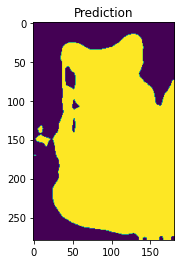

<Figure size 576x432 with 0 Axes>

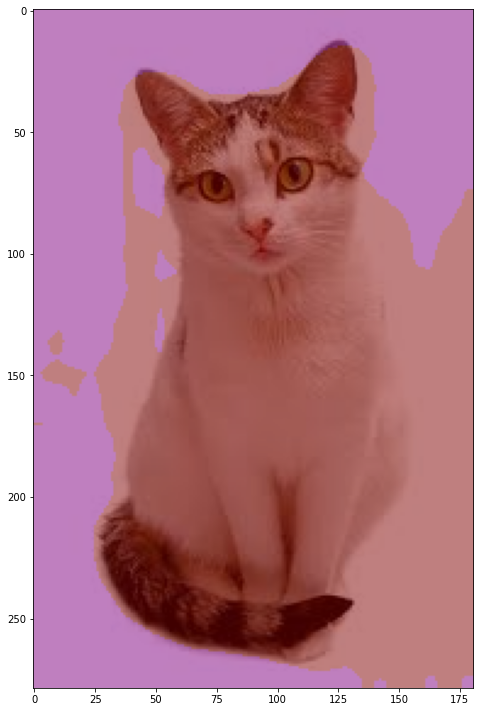

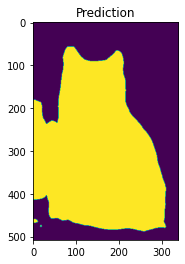

<Figure size 576x432 with 0 Axes>

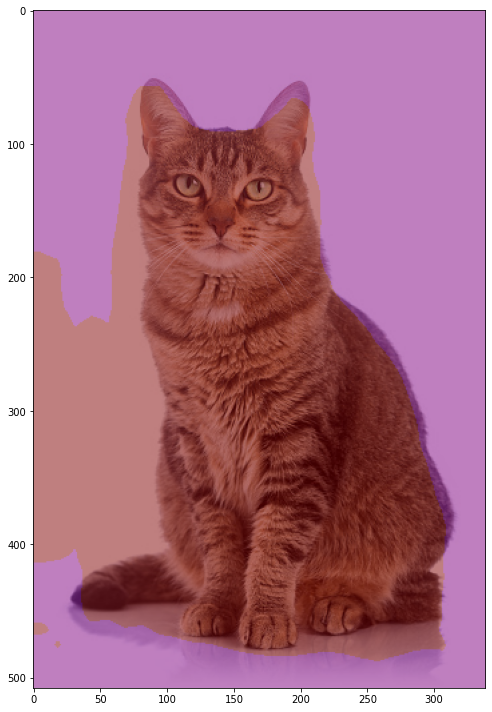

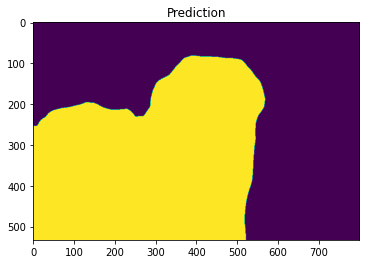

<Figure size 576x432 with 0 Axes>

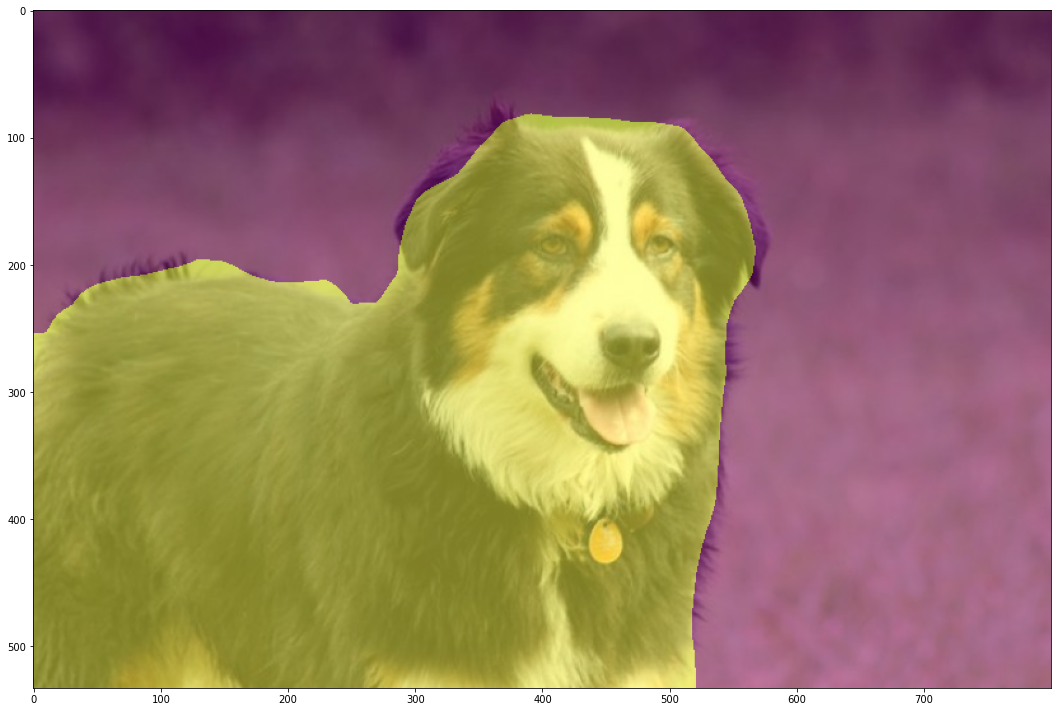

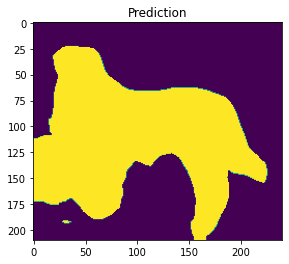

<Figure size 576x432 with 0 Axes>

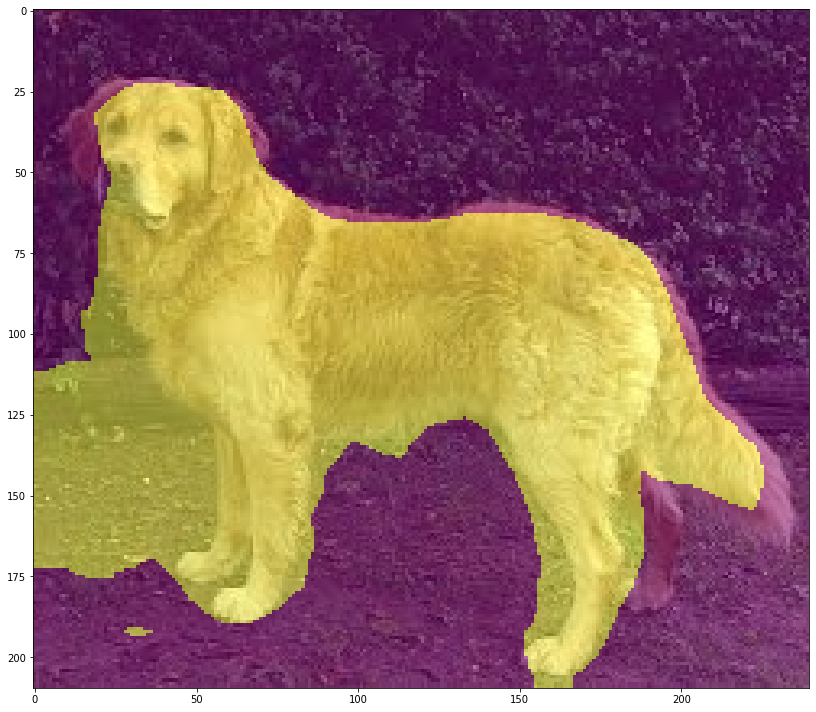

In [26]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob
import zipfile

#PATH_TO_TEST_IMAGES_DIR= data_root+dataset+"/img_dir/val"
PATH_TO_TEST_IMAGES_DIR= "/content/test_images/"


TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))


TEST_IMAGE_PATHS.sort()


checkpoint= 'work_dirs/tutorial/latest.pth' #checkpoint path
#model = init_segmentor(cfg, checkpoint, device='cuda:0')
model.cfg = cfg

palette = [[128, 0, 128], [128, 0, 0], [255,255,77]] # purple - maroon- ffff4d(yellow) 

print(len(TEST_IMAGE_PATHS))

for i in range(0, len(TEST_IMAGE_PATHS)):
  img = mmcv.imread(TEST_IMAGE_PATHS[i])
  result = inference_segmentor(model, img)
  
  arr= np.array(result)
  arr=np.squeeze(arr)

  plt.imshow(arr)
  plt.title("Prediction")
  plt.figure(figsize=(8, 6))

  show_result_pyplot(model, img, result,palette)

# Test Images 2 ( included in training)

4


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


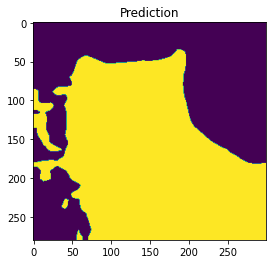

<Figure size 576x432 with 0 Axes>

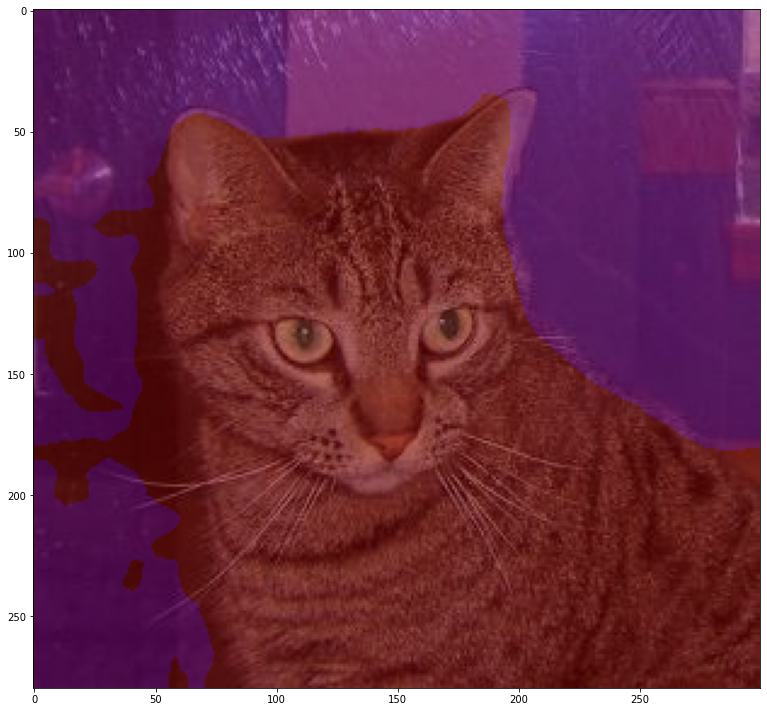

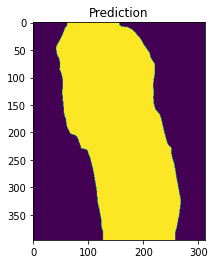

<Figure size 576x432 with 0 Axes>

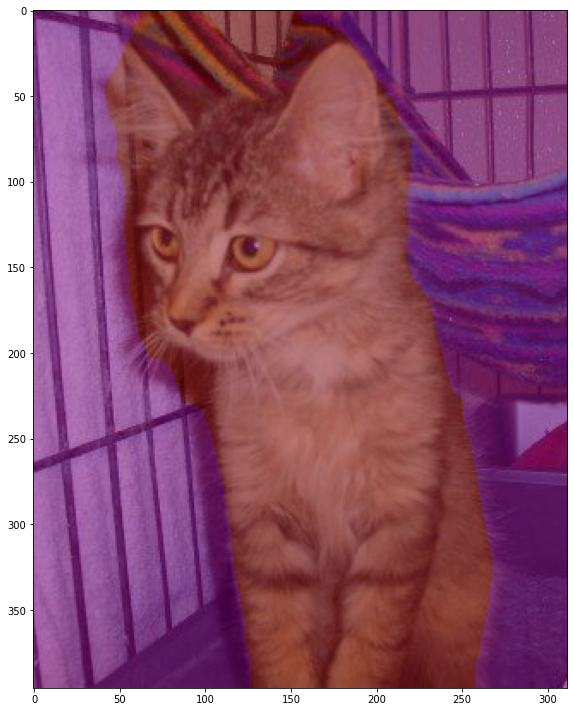

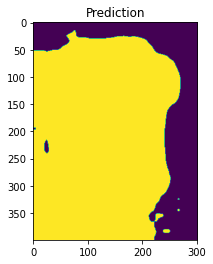

<Figure size 576x432 with 0 Axes>

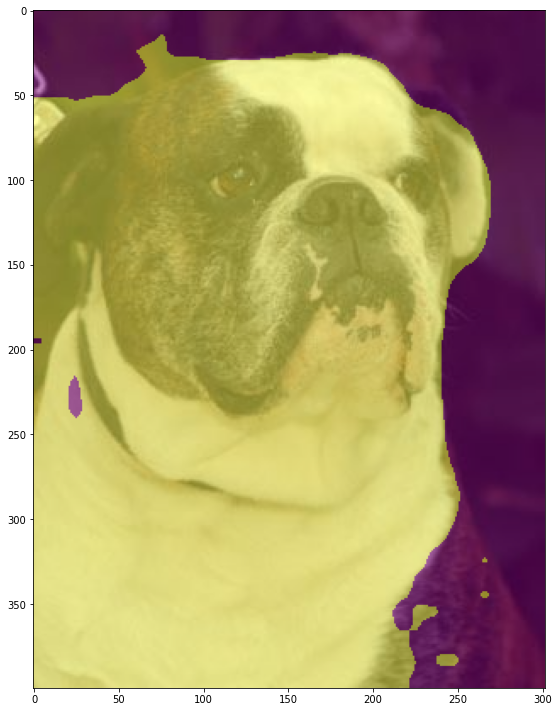

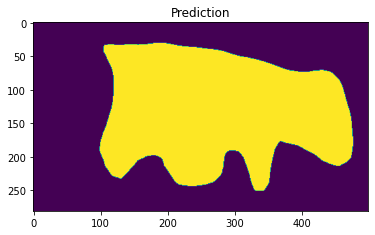

<Figure size 576x432 with 0 Axes>

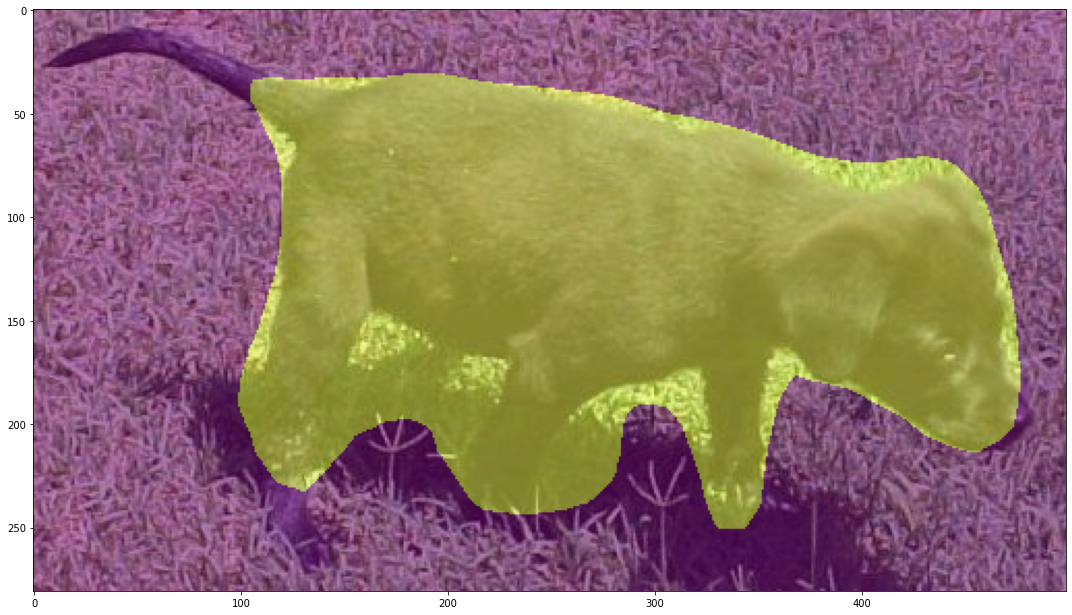

In [28]:


#PATH_TO_TEST_IMAGES_DIR= data_root+dataset+"/img_dir/val"
PATH_TO_TEST_IMAGES_DIR= "/content/test_images_from_Training/"


TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))


TEST_IMAGE_PATHS.sort()

print(len(TEST_IMAGE_PATHS))

for i in range(0, len(TEST_IMAGE_PATHS)):
  img = mmcv.imread(TEST_IMAGE_PATHS[i])
  result = inference_segmentor(model, img)
  
  arr= np.array(result)
  arr=np.squeeze(arr)

  plt.imshow(arr)
  plt.title("Prediction")
  plt.figure(figsize=(8, 6))

  show_result_pyplot(model, img, result,palette)